In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import urllib.parse
import datetime as dt
import requests
import psycopg2
import sys

from secret import *
from sshtunnel import SSHTunnelForwarder

# --- Constants ---
# Weather Variables in parsed format (See https://open-meteo.com/en/docs#api-documentation)
hourly_weather_variables = {
    'temperature' : ['temperature_2m', 'dewpoint_2m', 'apparent_temperature'],
    'humidity' : ['relativehumidity_2m'],
    'pressure' : ['pressure_msl', 'surface_pressure'],
    'clouds' : ['cloudcover', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high'],
    'wind' : ['windspeed_10m', 'windspeed_80m', 'windspeed_120m', 'windspeed_180m', 'winddirection_10m', 'winddirection_80m', 'winddirection_120m', 'winddirection_180m', 'windgusts_10m'],
    'radiation' : ['shortwave_radiation', 'direct_radiation', 'direct_normal_irradiance', 'diffuse_radiation'],
    'energy' : ['vapor_pressure_deficit', 'cape', 'evapotranspiration', 'et0_fao_evapotranspiration'],
    'precipitation' : ['precipitation', 'snowfall', 'precipitation_probability', 'rain', 'showers'],
    'weather' : ['weathercode'],
    'snow' : ['snow_depth', 'freezinglevel_height'],
    'visibility' : ['visibility'],
    'soil' : ['soil_temperature_0cm', 'soil_temperature_6cm', 'soil_temperature_18cm', 'soil_temperature_54cm', 'soil_moisture_0_1cm', 'soil_moisture_1_3cm', 'soil_moisture_3_9cm', 'soil_moisture_9_27cm', 'soil_moisture_27_81cm']
}
daily_weather_variables = {
    'temperature' : ['temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max', 'apparent_temperature_min'],
    'precipitation' : ['precipitation_sum', 'rain_sum', 'showers_sum', 'snowfall_sum', 'precipitation_hours', 'precipitation_probability_max', 'precipitation_probability_min', 'precipitation_probability_mean'],
    'weather' : ['weathercode', 'sunrise', 'sunset'],
    'wind' : ['windspeed_10m_max', 'windgusts_10m_max', 'winddirection_10m_dominant'],
    'radiation' : ['shortwave_radiation_sum'],
    'energy' : ['et0_fao_evapotranspiration'],
    'uv' : ['uv_index_max', 'uv_index_clear_sky_max']
}
# --- Weather Retrieval Functions ---

# Base OpenMeteo API call
def obtain_openmeteo_historical(start : dt.date, end : dt.date, lat : float, lon : float, weather_variables : dict) -> pd.DataFrame:
    url = "https://archive-api.open-meteo.com/v1/archive"
    hourly_params = weather_variables.get('hourly', [])
    daily_params = weather_variables.get('daily', [])
    params = {'latitude' : lat, 
              'longitude' : lat, 
              'start_date' : start.strftime('%Y-%m-%d'), 
              'end_date' : end.strftime('%Y-%m-%d'), 
              'hourly' : ','.join(hourly_params),
              'daily' : ','.join(daily_params),
              'timezone' : 'UTC'
              }
    try:
        response = requests.get(url, params=urllib.parse.urlencode(params, safe = ','))
        data = response.json()
        # Daily Data
        if 'daily' in data:
            daily = pd.DataFrame(data['daily'])
            daily['time'] = pd.to_datetime(daily['time'], format='%Y-%m-%dT%H:%M')
            daily['latitude'] = lat
            daily['longitude'] = lon
        else:
            daily = None
        # Hourly Data
        if 'hourly' in data:
            hourly = pd.DataFrame(data['hourly'])
            hourly['time'] = pd.to_datetime(hourly['time'], format='%Y-%m-%dT%H:%M')
            hourly['latitude'] = lat
            hourly['longitude'] = lon
        else:
            hourly = None      
        
        return daily, hourly
    except Exception as e:
        print(f"Failed to retrieve weather data from OpenMeteo API for ({lat}-{lon}) between {start.strftime('%Y-%m-%d')}-{end.strftime('%Y-%m-%d')}: {e}")
    
# Request an array of locations using OpenMeteo API
def obtain_openmeteo_historical_array(start : dt.date, end : dt.date, locations_array : list, weather_variables : dict) -> pd.DataFrame:
    daily, hourly = [], []
    for location in locations_array:
        lat, lon = location['coordinates']
        # Get rest of location data (e.g. name, elevation, etc.)
        location_metadata = {k:v for k,v in location.items() if k != 'coordinates'}
        daily_data, hourly_data = obtain_openmeteo_historical(start, end, lat, lon, weather_variables)
        if daily_data is not None:
            daily_data = daily_data.assign(**location_metadata)
            daily.append(daily_data)
        if hourly_data is not None:
            hourly_data = hourly_data.assign(**location_metadata)
            hourly.append(hourly_data)
    return pd.concat(daily), pd.concat(hourly)

# --- Database Retrieval Functions (SSH) ---
def load_connection(user: str,password: str,host: str,database: str, port):
    pg_connection_dict = {
    'dbname': database,
    'user': user,
    'password': password,
    'port': port,
    'host': host
    }
    keepalive_kwargs = {"keepalives": 1,"keepalives_idle": 250,"keepalives_interval": 5,"keepalives_count": 5}
    try:
        connection = psycopg2.connect(**pg_connection_dict, **keepalive_kwargs)
        return connection
    except(Exception, EnvironmentError) as e:
        raise Exception ("Error in connection, }".format(e))
        
def load_query(connection, query) -> pd.DataFrame:
    try:
        cursor = connection.cursor()
        cursor.execute(query) 
        record = cursor.fetchall()
        # Convert to pandas
        df_record = pd.DataFrame.from_records(record, columns =[x[0] for x in cursor.description])
        return df_record

    except(Exception,EnvironmentError) as e:
        raise Exception ("Error while fetching data from postgres, }".format(e))
    finally:
        # Close connection
        if(connection):
            cursor.close()



#### Examples of Data Retrieval

In [ ]:
server = SSHTunnelForwarder(
    (REMOTE_HOST, 22),
    ssh_username=REMOTE_USER,
    ssh_password=REMOTE_PASS,
    remote_bind_address=('localhost', DB_PORT)
)

query = """
SELECT datetime_start_utc AS "time", price_area, biomass, fossil_brown_coal_lignite, fossil_coal_derived_gas, fossil_gas, fossil_hard_coal, fossil_oil, geothermal, hydro_pumped_storage, hydro_run_of_river_and_poundage, hydro_water_reservoir, nuclear, other, other_renewable, solar, waste, wind_offshore, wind_onshore
FROM scraper.entsoe_generation_production
WHERE price_area IN ('NL') AND "datetime_start_utc" BETWEEN '2023-01-01' AND '2023-12-31'
GROUP BY "time","price_area"
ORDER BY "time"
"""
server.start()
connection = load_connection(user=DB_USER, password=DB_PASS, host='localhost', database = 'raw', port = server.local_bind_port)
df = load_query(connection, query)
server.stop()

#print(df.head(10))

location_eindhoven = {'coordinates' : (51.441642, 5.469722), 'city' : 'Eindhoven', 'country' : 'NL'}
w_variables = {
    'daily' : ['temperature_2m_max', 'temperature_2m_min', 'windspeed_10m_max', 'windgusts_10m_max','shortwave_radiation_sum'],
    'hourly' : ['temperature_2m', 'windspeed_10m','windspeed_100m', 'windgusts_10m', 'shortwave_radiation']
}

print(w_variables)
w_daily, w_hourly = obtain_openmeteo_historical_array(
    dt.date(2020,1,1), 
    dt.date(2022,12,31), 
    [location_eindhoven],
    weather_variables=w_variables)

w_hourly


In [ ]:
# Create a graph of the weather data using matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(w_hourly['time'], w_hourly['temperature_2m'], label='Temperature')
ax.plot(w_hourly['time'], w_hourly['windspeed_10m'], label='Wind Speed')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (C), Wind Speed (m/s)')
ax.set_title('Weather Data for Eindhoven')
ax.legend()
plt.show()

### Section 1: Preliminary Data Analysis
#### 1.0: Constants

In [2]:
TSO_COUNTRIES = {
"SK" : "Slovakia",
"DK" : "Denmark",
"LT" : "Lithuania",
"SI" : "Slovenia",
"CZ" : "Czech Republic",
"FR" : "France",
"LV" : "Latvia",
"RO" : "Romania",
"NL" : "Netherlands",
"EE" : "Estonia",
"HU" : "Hungary",
"AT" : "Austria",
"FI" : "Finland",
"PL" : "Poland",
"ES" : "Spain",
"PT" : "Portugal",
"NO" : "Norway",
"BG" : "Bulgaria",
"IT" : "Italy",
"HR" : "Croatia",
"SE" : "Sweden",
"GR" : "Greece",
"CH" : "Switzerland",
"BE" : "Belgium",
"DE" : "Germany"
}

# Regions are North Western Europe, mediterranean, eastern, western, baltic, central, southern, scandinavia
LOCATIONS = [
    {"city" : "Bratislava", "coordinates": (48.148598, 17.107748), "country": "SK", "region": "Eastern Europe"},
    {"city" : "Košice", "coordinates": (48.720595, 21.257698), "country": "SK", "region": "Eastern Europe"},
    {"city" : "Copenhagen", "coordinates": (55.676097, 12.568337), "country": "DK", "region": "North Western Europe"},
    {"city" : "Aarhus", "coordinates": (56.162939, 10.203921), "country": "DK", "region": "North Western Europe"},
    {"city" : "Vilnius", "coordinates": (54.687157, 25.279652), "country": "LT", "region": "Baltic"},
    {"city" : "Kaunas", "coordinates": (54.898521, 23.903597), "country": "LT", "region": "Baltic"},
    {"city" : "Ljubljana", "coordinates": (46.056946, 14.505751), "country": "SI", "region": "Central Europe"},
    {"city" : "Maribor", "coordinates": (46.554650, 15.646049), "country": "SI", "region": "Central Europe"},
    {"city" : "Prague", "coordinates": (50.075539, 14.437800), "country": "CZ", "region": "Central Europe"},
    {"city" : "Brno", "coordinates": (49.195060, 16.606837), "country": "CZ", "region": "Central Europe"},
    {"city" : "Paris", "coordinates": (48.856614, 2.352222), "country": "FR", "region": "Mediterranean"},
    {"city" : "Marseille", "coordinates": (43.296482, 5.369780), "country": "FR", "region": "Mediterranean"},
    {"city" : "Riga", "coordinates": (56.949649, 24.105186), "country": "LV", "region": "Baltic"},
    {"city" : "Daugavpils", "coordinates": (55.874296, 26.536963), "country": "LV", "region": "Baltic"},
    {"city" : "Bucharest", "coordinates": (44.426765, 26.102537), "country": "RO", "region": "Eastern Europe"},
    {"city" : "Cluj-Napoca", "coordinates": (46.771210, 23.623635), "country": "RO", "region": "Eastern Europe"},
    {"city" : "Amsterdam", "coordinates": (52.370216, 4.895168), "country": "NL", "region": "North Western Europe"},
    {"city" : "Rotterdam", "coordinates": (51.920179, 4.481774), "country": "NL", "region": "North Western Europe"},
    {"city" : "Tallinn", "coordinates": (59.436962, 24.753574), "country": "EE", "region": "Baltic"},
    {"city" : "Tartu", "coordinates": (58.380624, 26.725056), "country": "EE", "region": "Baltic"},
    {"city" : "Budapest", "coordinates": (47.497913, 19.040236), "country": "HU", "region": "Central Europe"},
    {"city" : "Debrecen", "coordinates": (47.531604, 21.627312), "country": "HU", "region": "Central Europe"},
    {"city" : "Vienna", "coordinates": (48.208176, 16.373819), "country": "AT", "region": "Central Europe"},
    {"city" : "Graz", "coordinates": (47.070714, 15.439504), "country": "AT", "region": "Central Europe"},
    {"city" : "Helsinki", "coordinates": (60.169856, 24.938379), "country": "FI", "region": "Scandinavia"},
    {"city" : "Turku", "coordinates": (60.451810, 22.266630), "country": "FI", "region": "Scandinavia"},
    {"city" : "Warsaw", "coordinates": (52.229676, 21.012229), "country": "PL", "region": "Central Europe"},
    {"city" : "Lodz", "coordinates": (51.759250, 19.455983), "country": "PL", "region": "Central Europe"},
    {"city" : "Madrid", "coordinates": (40.416775, -3.703790), "country": "ES", "region": "Mediterranean"},
    {"city" : "Barcelona", "coordinates": (41.385064, 2.173403), "country": "ES", "region": "Mediterranean"},
    {"city" : "Lisbon", "coordinates": (38.722252, -9.139337), "country": "PT", "region": "Mediterranean"},
    {"city" : "Porto", "coordinates": (41.157944, -8.629105), "country": "PT", "region": "Mediterranean"},
    {"city" : "Oslo", "coordinates": (59.913869, 10.752245), "country": "NO", "region": "Scandinavia"},
    {"city" : "Bergen", "coordinates": (60.392050, 5.322050), "country": "NO", "region": "Scandinavia"},
    {"city" : "Sofia", "coordinates": (42.697708, 23.321868), "country": "BG", "region": "Balkans"},
    {"city" : "Plovdiv", "coordinates": (42.135407, 24.745290), "country": "BG", "region": "Balkans"},
    {"city" : "Rome", "coordinates": (41.902782, 12.496366), "country": "IT", "region": "Mediterranean"},
    {"city" : "Milan", "coordinates": (45.464204, 9.189982), "country": "IT", "region": "Mediterranean"},
    {"city" : "Zagreb", "coordinates": (45.815011, 15.981919), "country": "HR", "region": "Balkans"},
    {"city" : "Split", "coordinates": (43.508132, 16.440193), "country": "HR", "region": "Balkans"},
    {"city" : "Stockholm", "coordinates": (59.329323, 18.068581), "country": "SE", "region": "Scandinavia"},
    {"city" : "Gothenburg", "coordinates": (57.708870, 11.974560), "country": "SE", "region": "Scandinavia"},
    {"city" : "Athens", "coordinates": (37.983810, 23.727539), "country": "GR", "region": "Balkans"},
    {"city" : "Thessaloniki", "coordinates": (40.640060, 22.944420), "country": "GR", "region": "Balkans"},
    {"city" : "Zürich", "coordinates": (47.376887, 8.541694), "country": "CH", "region": "Central Europe"},
    {"city" : "Geneva", "coordinates": (46.204391, 6.143158), "country": "CH", "region": "Central Europe"},
    {"city" : "Brussels", "coordinates": (50.850340, 4.351710), "country": "BE", "region": "North Western Europe"},
    {"city" : "Antwerp", "coordinates": (51.219448, 4.402464), "country": "BE", "region": "North Western Europe"},
    {"city" : "Berlin", "coordinates": (52.520007, 13.404954), "country": "DE", "region": "North Western Europe"},
    {"city" : "Hamburg", "coordinates": (53.551086, 9.993682), "country": "DE", "region": "North Western Europe"},
]

W_VARIABLES = {
    'daily' : ['temperature_2m_max', 'temperature_2m_min', 'windspeed_10m_max', 'windgusts_10m_max'],
    'hourly' : ['temperature_2m', 'windspeed_10m','windspeed_100m', 'windgusts_10m']
}

START_DATE = dt.date(2000,1,1)
END_DATE = dt.date(2023,1,1)


#### 1.1: Data Retrieval

##### 1.1.1: Weather

In [ ]:
# Weather
w_daily, w_hourly = obtain_openmeteo_historical_array(
    START_DATE, 
    END_DATE, 
    LOCATIONS,
    weather_variables=W_VARIABLES)

w_daily

##### 1.1.2: Energy

In [3]:
# Energy

# Connect to remote database
server = SSHTunnelForwarder(
    (REMOTE_HOST, 22),
    ssh_username=REMOTE_USER,
    ssh_password=REMOTE_PASS,
    remote_bind_address=('localhost', DB_PORT)
)

# Create data retrieval functions
def get_hourly_entsoe_generation_production(start_date, end_date,country_list):
    query = f"""
    SELECT 
    date_trunc('hour', datetime_start_utc) AS "timestamp", 
    price_area, 
    country_code,
    AVG(biomass) AS biomass,
    AVG(fossil_brown_coal_lignite) AS fossil_brown_coal_lignite,
    AVG(fossil_coal_derived_gas) AS fossil_coal_derived_gas,
    AVG(fossil_gas) AS fossil_gas,
    AVG(fossil_hard_coal) AS fossil_hard_coal,
    AVG(fossil_oil) AS fossil_oil,
    AVG(geothermal) AS geothermal,
    AVG(hydro_pumped_storage) AS hydro_pumped_storage,
    AVG(hydro_run_of_river_and_poundage) AS hydro_run_of_river_and_poundage,
    AVG(hydro_water_reservoir) AS hydro_water_reservoir,
    AVG(nuclear) AS nuclear,
    AVG(other) AS other,
    AVG(other_renewable) AS other_renewable,
    AVG(solar) AS solar,
    AVG(waste) AS waste, 
    AVG(wind_offshore) AS wind_offshore,
    AVG(wind_onshore) AS wind_onshore
    FROM scraper.entsoe_generation_production
    WHERE price_area IN ('{"','".join(country_list)}')
    AND "datetime_start_utc" BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY "timestamp","price_area", "country_code"
    ORDER BY "timestamp"
    """
    server.start()
    connection = load_connection(user=DB_USER, password=DB_PASS, host='localhost', database = 'raw', port = server.local_bind_port)
    df = load_query(connection, query)
    server.stop()
    return df

def get_hourly_entsoe_day_ahead_forecast(start_date, end_date,country_list):
    query = f"""
    SELECT 
    date_trunc('hour', datetime_start_utc) AS "timestamp", 
    price_area, 
    country_code,
    AVG(solar) AS solar,
    AVG(wind_offshore) AS wind_offshore,
    AVG(wind_onshore) AS wind_onshore,
    AVG(forecasted_load) AS forecasted_load,
    AVG(actual_aggregated) AS actual_aggregated
    FROM scraper.entsoe_da_forecast
    WHERE price_area IN ('{"','".join(country_list)}')
    AND "datetime_start_utc" BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY "timestamp","price_area", "country_code"
    ORDER BY "timestamp"
    """
    server.start()
    connection = load_connection(user=DB_USER, password=DB_PASS, host='localhost', database = 'raw', port = server.local_bind_port)
    df = load_query(connection, query)
    server.stop()
    return df


def get_hourly_entsoe_day_ahead_prices(start_date, end_date,country_list):
    query = f"""
    SELECT 
    date_trunc('hour', datetime_start_utc) AS "timestamp", 
    price_area, 
    country_code,
    AVG(price) AS price
    FROM scraper.entsoe_da_prices
    WHERE price_area IN ('{"','".join(country_list)}')
    AND "datetime_start_utc" BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY "timestamp","price_area", "country_code"
    ORDER BY "timestamp"
    """
    server.start()
    connection = load_connection(user=DB_USER, password=DB_PASS, host='localhost', database = 'raw', port = server.local_bind_port)
    df = load_query(connection, query)
    server.stop()
    return df

hourly_entsoe_day_ahead_forecast = get_hourly_entsoe_day_ahead_forecast(START_DATE, END_DATE, list(TSO_COUNTRIES.keys()))
hourly_entsoe_generation_production = get_hourly_entsoe_generation_production(START_DATE, END_DATE, list(TSO_COUNTRIES.keys()))
hourly_entsoe_day_ahead_prices = get_hourly_entsoe_day_ahead_prices(START_DATE, END_DATE, list(TSO_COUNTRIES.keys()))

#### 1.3: Data Visualisation

#### 1.3.1: Wind Speed

In [ ]:
import seaborn as sns

df = w_hourly.copy()
# groupby region, city, and country and resample to weekly
df = df.groupby(['region', 'city', 'country']).resample('M', on='time').mean().reset_index()
df['label'] = df['city'] + ' (' + df['country'] + ')'

fig, axes = plt.subplots(7, 1, figsize=(10, 20), sharex=False)
for i, region in enumerate(df['region'].unique()):
    sns.lineplot(data=df[df['region'] == region], x='time', y='windspeed_10m', hue='label', ax=axes[i])
    # Smaller line width
    for j in range(0, len(axes[i].lines)):
        axes[i].lines[j].set_linewidth(1.5)
        axes[i].lines[j].set_alpha(0.5)
    axes[i].set_title(region)
    # Set axis labels to '' to avoid overlapping
    axes[i].set_ylabel('Wind Speed (m/s)')
    axes[i].set_xlabel('')
    # Rotate xticks
    axes[i].tick_params(axis='x', rotation=45)
    # Legends outside the plot
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 2)
    # Create more space between the plots
fig.subplots_adjust(hspace=0.5)
plt.show()
 

In [ ]:
# Investigate the distribution of wind speed for each city
df = w_hourly.copy()
# groupby region, city, and country and resample to weekly
#df = df.groupby(['region', 'city', 'country']).resample('D', on='time').mean().reset_index()
df['label'] = df['city'] + ' (' + df['country'] + ')'

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    _title = old_legend.get_title().get_text()
    # Check if title in **kws
    if 'title' in kws:
        _title = kws['title']
        del kws['title']
    ax.legend(handles, labels, loc=new_loc, title=_title, **kws)
    
fig, axes = plt.subplots(7, 1, figsize=(10, 20), sharex=True)
for i, region in enumerate(df['region'].unique()):
    
    sns.histplot(data=df[df['region'] == region], x='windspeed_10m', hue='label', ax=axes[i], bins=50, alpha = 0.5)
    axes[i].set_title(region)
    axes[i].set_ylabel('Frequency')
    # Show xlabel for all plots
    # Show the xticks for all plots
    axes[i].xaxis.set_tick_params(which='both', labelbottom=True)
    axes[i].set_xlabel('Wind Speed (m/s)')
    # Show legend despite No artists with labels found to put in legend.  Manually add the legend values
    move_legend(axes[i], 2, ncol=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., title = '')
    # Xaxis max of 50 m/s
    axes[i].set_xlim(0, 50)
# Add legend outside the plot
fig.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# Check whether the data is lognormally distributed, take the log of the data and plot the distribution
df = w_hourly.copy()
#df = df[df['country'] == 'NL']
# groupby region, city, and country and resample to weekly
#df = df.groupby(['region', 'city', 'country']).resample('D', on='time').mean().reset_index()
df['label'] = df['city'] + ' (' + df['country'] + ')'
# Take log of wind speed (when wind speed is 0, take the log of 0.01)
df['log_windspeed_10m'] = np.log(df['windspeed_10m'].apply(lambda x: x if x > 0 else 0.01))

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    _title = old_legend.get_title().get_text()
    # Check if title in **kws
    if 'title' in kws:
        _title = kws['title']
        del kws['title']
    ax.legend(handles, labels, loc=new_loc, title=_title, **kws)
    
fig, axes = plt.subplots(7, 1, figsize=(10, 20), sharex=True)
for i, region in enumerate(df['region'].unique()):
    
    sns.histplot(data=df[df['region'] == region], x='log_windspeed_10m', hue='label', ax=axes[i], bins=50, alpha = 0.5)
    axes[i].set_title(region)
    axes[i].set_ylabel('Frequency')
    # Show xlabel for all plots
    # Show the xticks for all plots
    axes[i].xaxis.set_tick_params(which='both', labelbottom=True)
    axes[i].set_xlabel('Logarithmic Wind Speed')
    # Show legend despite No artists with labels found to put in legend.  Manually add the legend values
    move_legend(axes[i], 2, ncol=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., title = '')
# Add legend outside the plot
fig.subplots_adjust(hspace=0.5)
plt.show()

#### 1.3.2: Temperature

In [3]:
import seaborn as sns

df = w_hourly.copy()
# groupby region, city, and country and resample to weekly
df = df.groupby(['region', 'city', 'country']).resample('M', on='time').mean().reset_index()
df['label'] = df['city'] + ' (' + df['country'] + ')'

fig, axes = plt.subplots(7, 1, figsize=(10, 20), sharex=False)
for i, region in enumerate(df['region'].unique()):
    sns.lineplot(data=df[df['region'] == region], x='time', y='temperature_2m', hue='label', ax=axes[i])
    # Smaller line width
    for j in range(0, len(axes[i].lines)):
        axes[i].lines[j].set_linewidth(1.5)
        axes[i].lines[j].set_alpha(0.5)
    axes[i].set_title(region)
    # Set axis labels to '' to avoid overlapping
    axes[i].set_ylabel('Temperature (C)')
    axes[i].set_xlabel('')
    # Rotate xticks
    axes[i].tick_params(axis='x', rotation=45)
    # Legends outside the plot
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 2)
    # Create more space between the plots
fig.subplots_adjust(hspace=0.5)
plt.show()

NameError: name 'w_hourly' is not defined

#### 1.3.3: Energy

In [2]:
%history -g

 1/1:
from entsog import EntsogPandasClient
import pandas as pd

client = EntsogPandasClient()

start = pd.Timestamp('20171201', tz='Europe/Brussels')
end = pd.Timestamp('20180101', tz='Europe/Brussels')

points = client.query_operator_point_directions()
mask = points['connected_operators'].str.contains('Gazprom')
masked_points = points[mask]
print(masked_points)
 1/2:
from entsog import EntsogPandasClient
import pandas as pd

client = EntsogPandasClient()

start = pd.Timestamp('20171201', tz='Europe/Brussels')
end = pd.Timestamp('20180101', tz='Europe/Brussels')

points = client.query_operator_point_directions()
mask = points['connected_operators'].str.contains('Gazprom')
masked_points = points[mask]
print(masked_points.head(25))
 1/3:
from entsog import EntsogPandasClient
import pandas as pd

client = EntsogPandasClient()

start = pd.Timestamp('20171201', tz='Europe/Brussels')
end = pd.Timestamp('20180101', tz='Europe/Brussels')

points = client.query_operator_point_directions()
mask

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

df = hourly_entsoe_day_ahead_prices.copy()
df = df.groupby(['country_code', 'price_area']).resample('M', on='timestamp').mean().reset_index()

fig, axes = plt.subplots(1, 1, figsize=(12, 5), sharex=False)
i=0
sns.lineplot(data=df, x='timestamp', y='price', hue='price_area', ax=axes)
# Smaller line width
for j in range(0, len(axes.lines)):
    axes.lines[j].set_linewidth(1.5)
    axes.lines[j].set_alpha(0.5)
axes.set_title('Day Ahead Prices')
# Set axis labels to '' to avoid overlapping
axes.set_ylabel('Price (EUR/MWh)')
axes.set_xlabel('')
# Rotate xticks
axes.tick_params(axis='x', rotation=45)
# Legends outside the plot
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 2)
# Create more space between the plots
fig.subplots_adjust(hspace=0.5)

#### 1.3.4: Temporaral variability

In [4]:
# Print numpy version
print(np.__version__)
import seaborn as sns
print(sns.__version__)

1.24.1
0.11.2


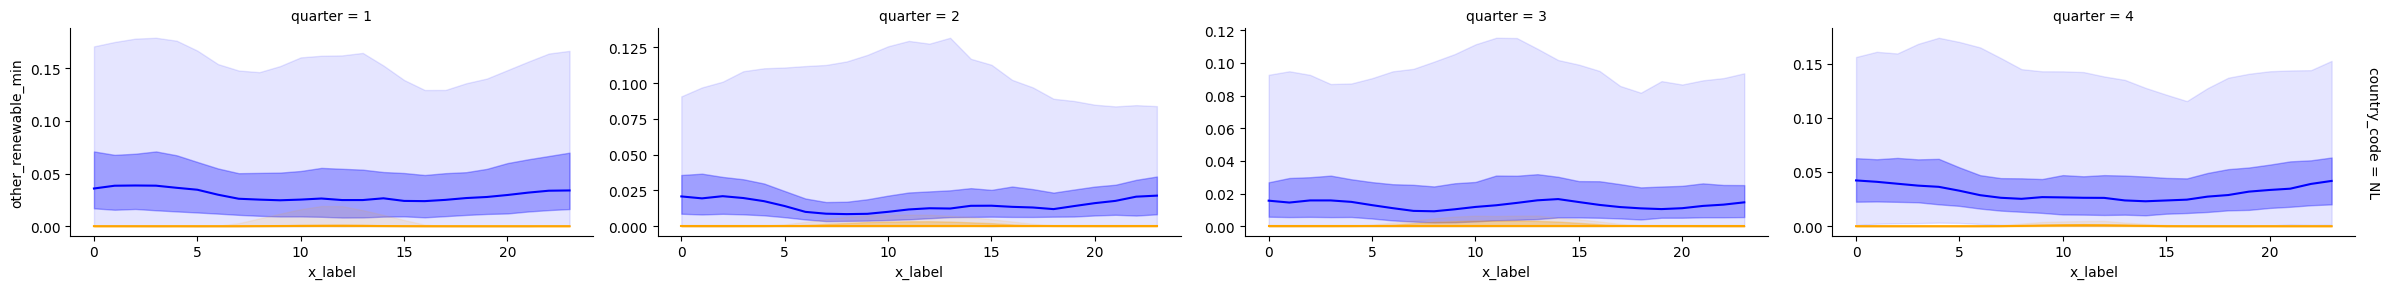

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

# Merge the three dataframes
df = pd.merge(hourly_entsoe_generation_production, hourly_entsoe_day_ahead_prices, on=['timestamp', 'country_code', 'price_area'])
df = pd.merge(df, hourly_entsoe_day_ahead_forecast[['timestamp', 'price_area', 'country_code', 'forecasted_load']], on=['timestamp', 'country_code', 'price_area'])
# Select only NL and DE
df = df[df['country_code'].isin(['NL', 'DE', 'FR', 'BE', 'LU'])]

# Sum over price_area
df = df.groupby(['timestamp', 'country_code']).sum().reset_index()

# Divide the columns from hourly_entsoe_generation_production with the forecasted_load
for col in hourly_entsoe_generation_production.columns[3:]:
    df[col] = df[col] / df['forecasted_load']

# Create new columns for quarter and month
df['quarter'] = pd.DatetimeIndex(df['timestamp']).quarter
df['hour'] = pd.DatetimeIndex(df['timestamp']).hour
# Group the data by date
df['date'] = df['timestamp'].dt.date
# Change year of date to 2020
df['date'] = df['date'].apply(lambda x: x.replace(year=2020))

# Group the data by quarter, month, and country_code, and calculate median and std
# 25th Percentile
def q25(x):    
    return x.quantile(0.25)
# 75th Percentile
def q75(x):
    return x.quantile(0.75)

# Get mean, std, 25th percentile, 75th percentile, min, and max
grouped_quarters = df.groupby(['quarter', 'hour','country_code']).agg({
    'wind_onshore': ['median', 'std', 'min', 'max', q25, q75],
    'solar': ['median', 'std', 'min', 'max', q25, q75],
    'other_renewable': ['median', 'std', 'min', 'max', q25, q75],
    'fossil_gas': ['median', 'std', 'min', 'max', q25, q75],
    'price': ['median', 'std', 'min', 'max', q25, q75]
})

grouped_months = df.groupby(['date','country_code']).agg({
    'wind_onshore': ['median', 'std', 'min', 'max', q25, q75],
    'solar': ['median', 'std', 'min', 'max', q25, q75],
    'other_renewable': ['median', 'std', 'min', 'max', q25, q75],
    'fossil_gas': ['median', 'std', 'min', 'max', q25, q75],
    'price': ['median', 'std', 'min', 'max', q25, q75]
})

# Reset index and rename columns
grouped_quarters = grouped_quarters.reset_index()
grouped_quarters.columns = ['_'.join(col) for col in grouped_quarters.columns]
# Rename country_code_ to country_code
grouped_quarters = grouped_quarters.rename(columns={'country_code_': 'country_code', 'quarter_': 'quarter', 'hour_': 'x_label'})

grouped_months = grouped_months.reset_index()
grouped_months.columns = ['_'.join(col) for col in grouped_months.columns]
# Rename country_code_ to country_code
grouped_months = grouped_months.rename(columns={'country_code_': 'country_code', 'date_': 'x_label'})
grouped_months['quarter'] = 5

# Set up the plot
g = sns.FacetGrid(grouped_quarters, row='country_code', col='quarter', height=3, aspect=2, margin_titles=True, sharex=False, sharey=False)

# Plot wind, solar, renewable, fossil, and price
g.map(plt.plot, 'x_label', 'wind_onshore_median', color='blue')
g.map(plt.fill_between, 'x_label', 'wind_onshore_q25', 'wind_onshore_q75', alpha=0.3, color='blue')
g.map(plt.fill_between, 'x_label', 'wind_onshore_min', 'wind_onshore_max', alpha=0.1, color='blue')

g.map(plt.plot, 'x_label', 'solar_median', color='orange')
g.map(plt.fill_between, 'x_label', 'solar_q25', 'solar_q75', alpha=0.3, color='orange')
g.map(plt.fill_between, 'x_label', 'solar_min', 'solar_max', alpha=0.1, color='orange')

g.map(plt.plot, 'x_label', 'other_renewable_median', color='green')
g.map(plt.fill_between, 'x_label', 'other_renewable_q25', 'other_renewable_q75', alpha=0.3, color='green')
g.map(plt.fill_between, 'x_label', 'other_renewable_min', 'other_renewable_max', alpha=0.1, color='green')
 
#g.map(plt.plot, 'hour', 'fossil_gas_median', color='red')
#g.map(plt.fill_between, 'hour', 'fossil_gas_q25', 'fossil_gas_q75', alpha=0.3, color='red')
#g.map(plt.fill_between, 'hour', 'fossil_gas_min', 'fossil_gas_max', alpha=0.1, color='red')

#g.map(plt.plot, 'hour', 'price_median', color='black')
#g.map(plt.fill_between, 'hour', 'price_q25', 'price_q75', alpha=0.3, color='black')
#g.map(plt.fill_between, 'hour', 'price_min', 'price_max', alpha=0.1, color='black')

# Double axis for price
# Set plot title, axis labels, and legend
g.fig